# Vortex center glow

The aim of this simulation is to model the vortex center glow effect, which is caused to diffraction of the thermal emission from the environment outside the entrance pupil to the pupil image formed on the detector, by the vortex phase mask. 
To model the effect, several points outside the entrance pupil are taken and their intensity on the detector is evaluated. Net effect is determined by adding contributions from all these points.

### Imports

In [1]:
import heeps
from heeps.optics.lens import lens, lens_offset
from heeps.optics.vortex_init import vortex_init
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img, crop_img, pad_img, get_radial_profile
from heeps.optics import lyot_stop, detector
from heeps.pupil.create_pupil import create_pupil
from copy import deepcopy
import proper
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=200)
import os.path
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
import multiprocessing as mpro
from functools import partial
from sys import platform
import time
%matplotlib inline

### Input parameters

In [2]:
diam_ext_cold_stop = 40.944
diam_int_cold_stop = 7.363
diam_ext_eff = 37.812
diam_int_eff = 10.196
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
# nominal diameters
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
r_spot = 0.2 # m
ncrop = 101 # for psf visualization
L_flux_env_per_m2 = 1.213e+03 # [photons/s/m2/pix]
L_flux_spi_per_m2 = 1.001e+03 # [photons/s/m2/pix]
L_flux_env = 3.3403e+05 # [photons/s/pix]
L_flux_spi = 0.4478e+05 # [photons/s/pix]
L_flux_std_bkgrd = 3.0747e+05 # [photons/s/pix]
N2_flux_env_per_m2 = 594.8e+03 # [photons/s/m2/pix]
N2_flux_spi_per_m2 = 494.3e+03 # [photons/s/m2/pix]
N2_flux_env = 3.3403e+05 # [photons/s/pix]
N2_flux_spi = 0.4478e+05 # [photons/s/pix]
N2_flux_std_bkgrd = 1.2821e+08 # [photons/s/pix]

### Initialize wavefront using PROPER

In [3]:
conf = dict(
#    dir_current = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/VCG',
    band = 'L',
    mode = 'CVC',
    file_lyot_stop = 'pupil/ls_0.0_0.0_0.0317_293.fits',
    dir_output = 'VCG/2Dmap',
    cpu_count = None,
    hfov = 1,
    pupil_img_size = diam_ext_cold_stop + 2*r_spot,
    diam_ext = diam_ext_cold_stop, 
    diam_int = diam_int_cold_stop,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
dir_current = conf['dir_current']
dir_output = conf['dir_output']
npupil = conf['npupil']
ngrid = conf['ngrid']
diam_ext = conf['diam_ext']
pupil_img_size = conf['pupil_img_size']
lam = conf['lam']
pscale = conf['pscale']
spi_width = conf['spi_width']
ndet = conf['ndet']
cpu_count = conf['cpu_count']
beam_ratio = npupil/ngrid*(diam_ext/pupil_img_size)
wf = proper.prop_begin(pupil_img_size, lam, ngrid, beam_ratio)
wf_pup = heeps.pupil.pupil(savefits=True, verbose=False, **conf)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2834
   npupil=293, pscale=5.47 mas, lam=3.8318E-06 m
   hfov=1.0 arcsec (-> ndet=365, 51.71 lam/D)



### Create cold stop

(293, 293)


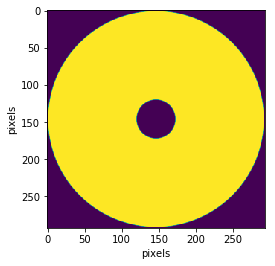

In [4]:
conf_stop = dict(conf, spi_width=0, seg_width=0)
cold_stop = heeps.pupil.create_pupil(**conf_stop)
print(cold_stop.shape)
plt.imshow(cold_stop), plt.xlabel('pixels'), plt.ylabel('pixels');
cold_stop = pad_img(cold_stop, ngrid)

### Create Lyot stop

In [5]:
def create_ls(d_ext, d_int, ls_dRext, ls_dRint, ls_dRspi):
    # create spider stop
    conf = dict(
        npupil=10526,
        pupil_img_size=40.944+(2*r_spot), 
        diam_ext=80,        # no circular aperture
        diam_int=0,         # no circular obscuration
        seg_width=0,        # no segments
        spi_width=spi_width + ls_dRspi*diam_nominal_ext,
    )
    mask_spi = create_pupil(**conf)
    # create outer and inner stops
    r_ext = (d_ext - ls_dRext*diam_nominal_ext) / (40.944+(2*r_spot))
    r_int = (d_int + ls_dRint*diam_nominal_ext) / (40.944+(2*r_spot))
    r, t = polar_coord(10526)
    mask_ext = (r < r_ext) 
    mask_int = (r > r_int) 
    # lyot stop
    return mask_spi * mask_ext * mask_int

### Create a spot, normalized by square meter of surface

In [6]:
def create_spot(rad, theta, nimg=10526):
    x, y = cart_coord(nimg)
    x *= pupil_img_size/2
    y *= pupil_img_size/2
    c = (rad*np.cos(np.deg2rad(theta)), rad*np.sin(np.deg2rad(theta)))
    r =  np.abs((x-c[0]) + 1j*(y-c[1]))
    spot = (r <= r_spot)                    # create a spot
    spot = resize_img(spot, npupil)         # resize to npupil
    spot = pad_img(spot, ngrid)             # pad with zeros
    # normalize the entrance pupil intensity (total flux = 1/spot_area)
    I_spot = spot**2
    spot_area = np.pi*r_spot**2
    spot = np.sqrt(I_spot/spot_area)
    return spot

### Generate points along spider edges

In [7]:
def points_along_spi_edge(rads, thetas):
    shift = spi_width/2 - r_spot
    r_spi_shift = []
    t_spi_left = []
    t_spi_right = []
    for rad in rads:
        for theta in thetas:
            r = np.sqrt(rad**2 + shift**2)
            t_l = theta + np.degrees(np.arctan(shift/rad))
            t_r = theta - np.degrees(np.arctan(shift/rad))
            r_spi_shift.append(r)
            t_spi_left.append(t_l)
            t_spi_right.append(t_r)
    r_spi_lr = r_spi_shift + r_spi_shift
    t_spi_lr = t_spi_left + t_spi_right
    return r_spi_lr, t_spi_lr

def points_along_spi_left_edge(rads, thetas):
    shift = spi_width/2 - r_spot
    r_spi_shift = []
    t_spi_left = []
    for rad in rads:
        for theta in thetas:
            r = np.sqrt(rad**2 + shift**2)
            t_l = theta + np.degrees(np.arctan(shift/rad))
            r_spi_shift.append(r)
            t_spi_left.append(t_l)
    return r_spi_shift, t_spi_left

def points_along_spi_right_edge(rads, thetas):
    shift = spi_width/2 - r_spot
    r_spi_shift = []
    t_spi_right = []
    for rad in rads:
        for theta in thetas:
            r = np.sqrt(rad**2 + shift**2)
            t_r = theta - np.degrees(np.arctan(shift/rad))
            r_spi_shift.append(r)
            t_spi_right.append(t_r)
    return r_spi_shift, t_spi_right

### Propagate functions

In [8]:
def fp_mask(wf, rad, mode='RAVC', focal=660, vc_zoffset=1e-3/2, verbose=False, **conf):
        if verbose is True:
            print('   apply vortex phase mask')                        
        # update conf
        conf.update(focal=focal)
        # propagate to vortex
        lens_offset(wf, focal, offset_after=vc_zoffset)
        # load vortex calibration files: psf_num, vvc, perf_num
        conf = vortex_init(verbose=verbose, **conf)
        # get maximum aplitude 
        amp_array = proper.prop_get_amplitude(wf)
        amp_max = np.amax(amp_array)
        #rescale flux
        if rad in r_int:
            proper.prop_multiply(wf, np.sqrt(L_flux_env_per_m2)/amp_max)
        elif rad in r_ext:
            proper.prop_multiply(wf, np.sqrt(L_flux_env_per_m2)/amp_max)
        elif rad in r_spi_lr:
            proper.prop_multiply(wf, np.sqrt(L_flux_spi_per_m2)/amp_max)
        # apply vortex
        scale_psf = wf._wfarr[0,0]/conf['psf_num'][0,0]
        wf_corr = (conf['psf_num']*conf['vvc'] - conf['perf_num'])*scale_psf
        wf._wfarr = wf._wfarr*conf['vvc'] - wf_corr
        # propagate to lyot stop
        lens_offset(wf, focal, offset_before=-vc_zoffset)
        return wf

In [9]:
def propag_one_spot(rad, theta, verbose=False):
        #print(rad, theta)
        # keep a copy of the input wavefront
        wf1 = deepcopy(wf)
        # create a normalized spot
        spot = create_spot(rad, theta)
        # add spot to wavefront
        proper.prop_multiply(wf1, spot)
        # apply cold stop
        proper.prop_multiply(wf1, cold_stop)
        # propagate one frame of onaxis psf (i.e. star)
        wf1 = fp_mask(wf1, rad, verbose=verbose, **conf)
        proper.prop_multiply(wf1, ls_mask)
        #wf1 = lyot_stop(wf1, verbose=verbose, **conf)
        psf = detector(wf1, verbose=verbose, **conf)
        return psf

In [10]:
def propag_multi_spots(rads, thetas, filename, cpu_count=cpu_count, verbose=False):
    nrads = len(rads)
    nthetas = len(thetas)
    print('radii = %s'%rads)
#    print('angles = %s'%thetas)
    if not os.path.isfile(filename):
        filename = os.path.join(dir_output, filename)
    try:
        cube = fits.getdata(filename)
        print('   Load cube from %s'%filename)
    except FileNotFoundError: # run simulation  
        cube = []
        t0 = time.time()
        if cpu_count != 1 and platform in ['linux', 'linux2', 'darwin']:
            if cpu_count == None:
                cpu_count = mpro.cpu_count() - 1
            print('   %s: VCG simulation starts, using %s cores'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), cpu_count))
            p = mpro.Pool(cpu_count)
            func = partial(propag_one_spot, verbose=verbose)
            if rads in r_int:
                cube = np.array(p.starmap(func, zip(np.repeat(rads, nthetas), np.tile(thetas, nrads))))
            elif rads in r_ext:
                cube = np.array(p.starmap(func, zip(np.repeat(rads, nthetas), np.tile(thetas, nrads))))
            elif rads in r_spi:
                spi_rads, spi_thetas =  points_along_spi_right_edge(rads, thetas)
                cube = np.array(p.starmap(func, zip(spi_rads, spi_thetas)))
            p.close()
            p.join()
        else:
            print('   %s: VCG simulation starts, using 1 core'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
            for rad in all_rads and theta in all_thetas:
                cube.append(propag_one_spot(rad, theta, verbose=verbose))
        print('   %s: finished, elapsed %.3f seconds'\
            %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), time.time() - t0))
    return np.array(cube)

#### Lyot stop undersize/oversize

In [ ]:
r_pups = np.arange(0.0, 0.061, 0.005)
r_spis = np.arange(0.0, 0.061, 0.005)
npup = len(r_pups)
nspi = len(r_spis)
vcg_psf = []
vcg_int = []
throughput = []
for r_pup in r_pups:
    for r_spi in r_spis:
        print('r_pup =', r_pup, 'r_spi =', r_spi)
        #create ls
        ls_mask = create_ls(diam_allglass_ext, diam_allglass_int, r_pup, r_pup, r_spi)
        ls_mask = resize_img(ls_mask, conf['npupil'])
        ls_mask = pad_img(ls_mask, conf['ngrid'])
        #VCG from points inside central obscuration
        r_int = np.arange(diam_int_eff/2 - r_spot, diam_int_cold_stop/2 - r_spot, -2*r_spot)
        t_int = np.arange(0,360,20)
        cube_int = propag_multi_spots(r_int, t_int, 'cube_int.fits')
        psf_r_int = []
        for i,r in enumerate(r_int):
            psf_r_int.append(np.sum(x*4*np.pi*r*r_spot/len(t_int) for x in cube_int[i*len(t_int):(i+1)*len(t_int)]))
        I_r_int = np.sum((psf_r_int), (1,2))
        psf_int = np.sum(psf_r_int, 0)
        # VCG from points beyond ELT pupil's outer edge
        r_ext = np.arange(diam_ext_eff/2 + r_spot, diam_ext_cold_stop/2 + r_spot, 2*r_spot)
        t_ext = np.arange(0, 360, 20)
        cube_ext = propag_multi_spots(r_ext, t_ext, 'cube_ext.fits')
        psf_r_ext = []
        for i,r in enumerate(r_ext):
            psf_r_ext.append(np.sum(x*4*np.pi*r*r_spot/len(t_ext) for x in cube_ext[i*len(t_ext):(i+1)*len(t_ext)]))
        I_r_ext = np.sum((psf_r_ext), (1,2))
        psf_ext = np.sum(psf_r_ext, 0)
        # VCG from points along spiders
        r_spi = np.arange(diam_int_eff/2 + r_spot, diam_ext_eff/2 - r_spot, 2*r_spot)
        t_spi = np.arange(30,360,60)
        r_spi_lr, t_spi_lr = points_along_spi_right_edge(r_spi, t_spi)
        cube_spi = propag_multi_spots(r_spi, t_spi, 'cube_spi.fits')
        psf_r_spi = []
        for i,r in enumerate(r_spi):
            psf_r_spi.append(np.sum(x*2*spi_width*r_spot for x in cube_spi[i*len(t_spi):(i+1)*len(t_spi)]))
        I_r_spi = np.sum((psf_r_spi), (1,2))
        psf_spi = np.sum(psf_r_spi, 0)
        # Total VCG from all sources: int + ext + spi
        psf_all = psf_int + psf_ext + psf_spi
        vcg_intensity = np.sum(psf_all)
        #throughput
        wf2 = deepcopy(wf_pup)
        proper.prop_multiply(wf2, ls_mask)
        psf_pup = detector(wf2, verbose=False, **conf)
        thruput = np.sum(psf_pup)
        vcg_psf.append(psf_all)
        vcg_int.append(vcg_intensity)
        throughput.append(thruput)
vcg_int = np.array(vcg_int)
vcg_int = vcg_int.reshape(npup, nspi)
throughput = np.array(throughput)
throughput = throughput.reshape(npup, nspi)
fits.writeto(os.path.join(dir_output, 'vcg_psf.fits'), np.float32(vcg_psf), overwrite=True)
np.savetxt(os.path.join(dir_output, 'vcg_int.txt'), vcg_int, delimiter=', ')
np.savetxt(os.path.join(dir_output, 'throughput.txt'), throughput, delimiter=', ')

r_pup = 0.0 r_spi = 0.0
radii = [4.898 4.498 4.098 3.698]
   2021-05-02 18:19:21: VCG simulation starts, using 55 cores
   2021-05-02 18:20:54: finished, elapsed 93.734 seconds
radii = [19.106 19.506 19.906 20.306]
   2021-05-02 18:20:55: VCG simulation starts, using 55 cores


#### VCG all

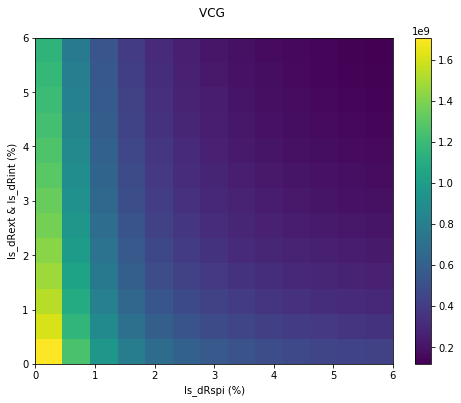

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
from astropy.io import fits
rp = np.arange(0.0, 0.061, 0.005)
rs = np.arange(0.0, 0.061, 0.005)
vcg = np.loadtxt('VCG/2Dmap/vcg_int.txt', delimiter=', ')
fig, ax = plt.subplots(figsize = (8,6))
plt.imshow(vcg, origin='lower', extent=(rs[0],rs[-1],rp[0],rp[-1]), aspect='auto', cmap='viridis')
plt.colorbar()
#plt.scatter(0.0317, 0.0291, s=150, c='red', marker='+')
plt.ylabel('ls_dRext & ls_dRint (%)');
plt.xlabel('ls_dRspi (%)');
plt.title('VCG \n ');
ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
plt.show()
#plt.savefig(os.path.join('VCG/2Dmap', '2Dmap.png'), dpi=300, transparent=True)

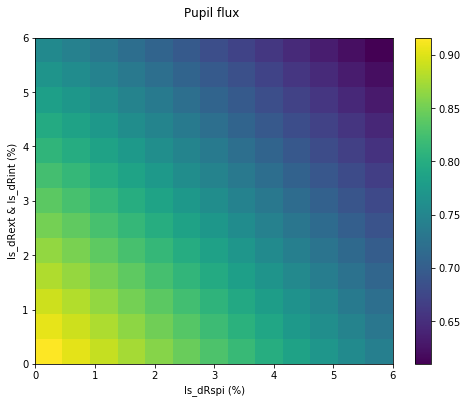

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
from astropy.io import fits
rp = np.arange(0.0, 0.061, 0.005)
rs = np.arange(0.0, 0.061, 0.005)
pupil_flux = np.loadtxt('VCG/2Dmap/throughput.txt', delimiter=', ')
fig, ax = plt.subplots(figsize = (8,6))
plt.imshow(pupil_flux, origin='lower', extent=(rs[0],rs[-1],rp[0],rp[-1]), aspect='auto', cmap='viridis')
plt.colorbar()
#plt.scatter(0.0317, 0.0291, s=150, c='red', marker='+')
plt.ylabel('ls_dRext & ls_dRint (%)');
plt.xlabel('ls_dRspi (%)');
plt.title('Pupil flux \n ');
ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
plt.show()
#plt.savefig(os.path.join('VCG/2Dmap', '2Dmap.png'), dpi=300, transparent=True)

#### SNR

##### taking only VCG flux

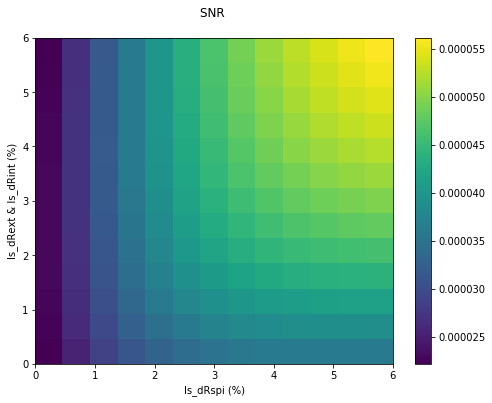

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
from astropy.io import fits
rp = np.arange(0.0, 0.061, 0.005)
rs = np.arange(0.0, 0.061, 0.005)
SNR = pupil_flux/np.sqrt(vcg)
fig, ax = plt.subplots(figsize = (8,6))
plt.imshow(SNR, origin='lower', extent=(rs[0],rs[-1],rp[0],rp[-1]), aspect='auto', cmap='viridis')
plt.colorbar()
#plt.scatter(0.0317, 0.0291, s=150, c='red', marker='+')
plt.ylabel('ls_dRext & ls_dRint (%)');
plt.xlabel('ls_dRspi (%)');
plt.title('SNR \n ');
ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
plt.show()
#plt.savefig(os.path.join('VCG/2Dmap', '2Dmap.png'), dpi=300, transparent=True)

##### VCG flux + standard background flux

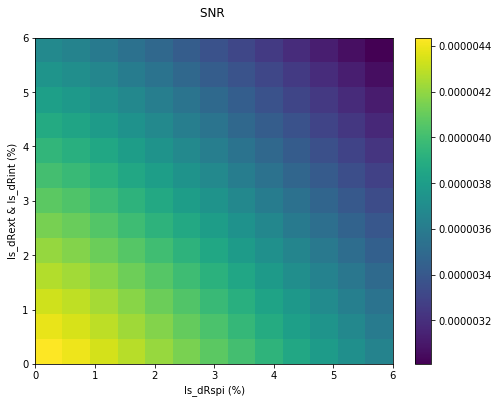

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
from astropy.io import fits
rp = np.arange(0.0, 0.061, 0.005)
rs = np.arange(0.0, 0.061, 0.005)
SNR = pupil_flux/np.sqrt(vcg+(L_flux_std_bkgrd*365*365))
fig, ax = plt.subplots(figsize = (8,6))
plt.imshow(SNR, origin='lower', extent=(rs[0],rs[-1],rp[0],rp[-1]), aspect='auto', cmap='viridis')
plt.colorbar()
#plt.scatter(0.0317, 0.0291, s=150, c='red', marker='+')
plt.ylabel('ls_dRext & ls_dRint (%)');
plt.xlabel('ls_dRspi (%)');
plt.title('SNR \n ');
ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
plt.show()
#plt.savefig(os.path.join('VCG/2Dmap', '2Dmap.png'), dpi=300, transparent=True)